In [1]:
#dataframes
import pandas as pd

import sys
sys.path.append('../../')
import odor_statistics_lib as osm

# user defined functions

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

#plots
from figurefirst import FigureLayout,mpl_functions
import figurefirst
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
import figurefirst as fifi
from IPython.display import display,SVG

np.set_printoptions(suppress=True)
import fly_plot_lib.plot as fpl
FS=7

In [2]:
dir = '../../../data/derived_data/'
fdf1 = pd.read_hdf(dir+"NotWindyStatsTime_std.h5")
fdf2 = pd.read_hdf(dir+"WindyStatsTime_std.h5")
fdf3 = pd.read_hdf(dir+"ForestStatsTime_std.h5")

fdf = pd.concat([fdf1,fdf2,fdf3])
fdf.reset_index(inplace=True, drop=True)

In [3]:
fdf.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source', 'avg_xsign',
       'avg_dist_from_streakline', 'log_avg_dist_from_source_signed',
       'mean_concentration', 'avg_parallel_encounter',
       'avg_perpendicular_encounter', 'avg_parallel_intermittency',
       'avg_perpendicular_intermittency', 'length_of_encounter',
       'odor_intermittency', 'log_whiff', 'log_blank',
       'speed_at_intermittency', 'speed_at_encounter', 'mean_ef', 'mean_ma',
       'mean_time', 'type', 'std_whiff', 'whiff_ma'],
      dtype='object')

In [4]:
dat=fdf

whiff_frequency=smf.ols(formula='mean_ef ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dat).fit()
whiff_duration=smf.ols(formula='log_whiff~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dat).fit()
moving_avg = smf.ols(formula='mean_ma ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dat).fit()
mc = smf.ols(formula='mean_concentration ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dat).fit()
wsd_ = smf.ols(formula='std_whiff ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dat).fit()


dat['wf']=whiff_frequency.resid
dat['wd'] = whiff_duration.resid
dat['wma'] = moving_avg.resid
dat['wc'] = mc.resid
dat['wsd']=wsd_.resid
    
distance=smf.ols(formula='log_avg_dist_from_source_signed~ wc + wd+wf  + wsd + wma', data=dat).fit()
# print(distance.summary())    

### Normality Analysis

In [5]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(distance.resid)
lzip(name, test)

[('Jarque-Bera', 228.74880014829918),
 ('Chi^2 two-tail prob.', 2.1273021391219935e-50),
 ('Skew', -0.3146936258100958),
 ('Kurtosis', 3.295921595858204)]

### Breusch Pagan Test
more about BP Test: https://stats.stackexchange.com/questions/155495/what-is-criterion-for-breusch-pagan-test

In [6]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(distance.resid, distance.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 98.78135056898329),
 ('p-value', 9.546739162602587e-20),
 ('f-value', 19.91918699244569),
 ('f p-value', 7.889446756269834e-20)]

### Diagnostic plots

Let's check that the assumptions of the model have not been violated. Specifically, we look to see:

* the residuals are well distributed (standardized residuals vs predicted)
* the residuals follow a normal distribution (shapiro-wilks test) since we are using a linear model, not generalized
* check the heteroscedasticity (Q-Q plot)
* the variance is not a function of the output (observed vs predicted)
As with the $R^2$ situation, we will look at predictions and residuals that include the fixed and random effects, or only the fixed, since we are using a mixed effects linear model.

Some useful stuff:

https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/

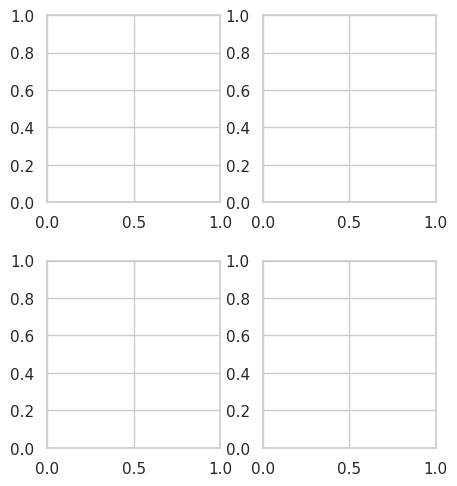

In [7]:
layout = fifi.svg_to_axes.FigureLayout('../../../Figure/normalityAnalysis.svg',
                                           autogenlayers=True, make_mplfigures=True, hide_layers=[])

### Actual vs Predicted

The scatter data should fall evenly around the red line, without any major patterns.


In [8]:
ax=layout.axes[('fig1','ax1')]
b, a = np.polyfit(distance.fittedvalues,fdf.log_avg_dist_from_source_signed, deg=1)
xseq = np.linspace(.3, 1.5, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="r", lw=1, rasterized=True);
ax.scatter(distance.fittedvalues, fdf.log_avg_dist_from_source_signed,
           s=4,color='b',rasterized=True)


ax.grid(False)
ax.set_rasterization_zorder(-20)

ax.set_xlabel('Predicted DFS')
ax.xaxis.set_label_coords(0.5, -.05)
ax.set_ylabel('Log (Measured DFS)')
ax.yaxis.set_label_coords(-0.06, 0.5)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left': 5, 'bottom': 5}, 
                            smart_bounds=True,
                            xticks=[0.2,1.4],
                            yticks=[-1,2],
                            linewidth=0.5)


figurefirst.mpl_functions.set_fontsize(ax, FS)

layout.append_figure_to_layer(layout.figures['fig1'], 'fig1', cleartarget=True)
layout.write_svg('../../../Figure/normalityAnalysis.svg')


### Standardized residuals
Standardized residuals = (observed - expected) / std_dev(expected)

The scatter should be evenly distributed around the red line, without any obvious patterns, like growing or shrinking residuals as a function of predicted value.

In [9]:
ax=layout.axes[('fig1','ax2')]

standardized_residuals = (fdf.log_avg_dist_from_source_signed - distance.fittedvalues) / np.std(distance.fittedvalues)
b, a = np.polyfit(distance.fittedvalues, standardized_residuals, deg=1)
xseq = np.linspace(.3, 1.5, num=100)


ax.plot(xseq, a + b * xseq, color="r", lw=1, rasterized=True);
ax.scatter(distance.fittedvalues, standardized_residuals,s=4,color='b',rasterized=True)
# ax.set_xlim(,1.2)
ax.grid(False)
ax.set_rasterization_zorder(-20)


ax.set_xlabel('Predicted DFS')
ax.xaxis.set_label_coords(0.5, -.05)
ax.set_ylabel('Standardized Residuals')
ax.yaxis.set_label_coords(-0.06, 0.5)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left': 5, 'bottom': 5}, 
                            smart_bounds=True,
                            xticks=[0.2,1.4],
                            yticks=[-15,10],
                            linewidth=0.5)


figurefirst.mpl_functions.set_fontsize(ax, FS)

layout.append_figure_to_layer(layout.figures['fig1'], 'fig1', cleartarget=True)
layout.write_svg('../../../Figure/normalityAnalysis.svg')

### Residual Analysis

### Q-Q plot
The scatter should follow the red line, especially in the middle. Looks pretty good here. The plots shows there is a central peak in distribution

In [10]:
ax=layout.axes[('fig1','ax3')]

stats.probplot(distance.resid,plot=ax)


ax.grid(False)
ax.set_rasterization_zorder(-20)
ax.set_rasterization_zorder(-20)

ax.set_xlabel('Theoretical Quantiles')
ax.xaxis.set_label_coords(0.5, -.05)
ax.set_ylabel('Ordered Values')
ax.yaxis.set_label_coords(-0.06, 0.5)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left': 5, 'bottom': 5}, 
                            smart_bounds=True,
                            xticks=[-4,4],
                            yticks=[-1.6,1.6],
                            linewidth=0.5)


ax.set_title('')
figurefirst.mpl_functions.set_fontsize(ax, FS)

layout.append_figure_to_layer(layout.figures['fig1'], 'fig1', cleartarget=True)
layout.write_svg('../../../Figure/normalityAnalysis.svg')

### Normality of residuals
The residuals should be normally distributed in this case, because we are using a linear model that assumes that the residuals are going to be normally distributed.

Not ideal here, there seem to be more small residuals than a normal distribution would predict.

** for hist plots density=True represents the frequency distribution

density=False represents the probability density distribution

In [11]:
ax=layout.axes[('fig1','ax4')]

ax.hist(standardized_residuals, density=True,color='b', stacked=True,rasterized=True)

rv = stats.norm(0, np.std(standardized_residuals))
x = np.linspace(-25,25,100)
pdf = rv.pdf(x)

ax.plot(x, pdf, color='red',lw=1,rasterized=True)

ax.grid(False)

ax.set_rasterization_zorder(-20)
ax.set_xlabel('Standardized\nResiduals')
ax.xaxis.set_label_coords(0.5, -.05)
ax.set_ylabel('Occurences')
ax.yaxis.set_label_coords(-0.06, 0.5)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left': 5, 'bottom': 5}, 
                            smart_bounds=True,
                            xticks=[-20,20],
                            yticks=[0,0.16],
                            linewidth=0.5)


# ax.set_title('ProbPlot of Regression Residuals')
figurefirst.mpl_functions.set_fontsize(ax, FS)

layout.append_figure_to_layer(layout.figures['fig1'], 'fig1', cleartarget=True)
layout.write_svg('../../../Figure/normalityAnalysis.svg')